# Imports:

In [1]:
import numpy as np
import GEOMODEL as GEOMODEL
import matplotlib.pyplot as plt
import matplotlib
import scipy.integrate as integ
import scienceplots
from cycler import cycler
import lal
import pycbc
import pycbc.waveform
from pycbc.waveform import Array
from pycbc.detector import Detector
import itertools
# %matplotlib widget
plt.style.use(['science','ieee','notebook'])
plt.rcParams.update({'figure.dpi': 150})
plt.rcParams['axes.prop_cycle'] = cycler('color', ['#1F77B4', '#FF7F0E', '#2CA02C', '#D62728', '#9467BD', '#8C564B', '#E377C2', '#7F7F7F', '#BCBD22', '#17BECF', '#9A0EEA'])
plt.rcParams.update({'font.serif': 'serif', 'font.family' : 'DeJavu Serif'})
plt.rcParams.update({
        'font.size': 21,
        'axes.labelsize': 21,
        'xtick.labelsize': 18,
        'ytick.labelsize': 18,
        'legend.fontsize': 16
    })
colors = ['#1F77B4', '#D62728', '#9467BD', 'gray','#17BECF', '#8C564B', '#E377C2', '#7F7F7F',  '#9A0EEA']

PyCBC.libutils: pkg-config call failed, setting NO_PKGCONFIG=1


# Graphing code:

In [48]:
def plot_ASD(ASD_List, labelsList, hAveList, freqsList):
    
    # Plot the ASDs by looping through the input NSR list and plotting every array value
    
    x_values = np.logspace(0,5,100000)
    plt.figure(figsize=(10, 8))
    
    plt.plot(freqsList[2], hAveList[2], label=r'$10^{-1}~M_{\odot}$', linestyle='-.', color='#9467BD',zorder=4, alpha=1)
    plt.plot(freqsList[1], hAveList[1], label=r'$10^{-2}~M_{\odot}$', linestyle='-.', color='#D62728',zorder=4, alpha=1)
    plt.plot(freqsList[0], hAveList[0], label=r'$10^{-3}~M_{\odot}$', linestyle='-.', color='#2CA02C',zorder=4, alpha=1)
    
    plt.plot(x_values, ASD_List[0], label=labelsList[0], zorder=3, color='#1F77B4', alpha=0.7) #, alpha=0.4
    i=1
    while i < len(ASD_List)-1:
        plt.plot(x_values, ASD_List[i], label=labelsList[i], zorder = i+2, color = colors[i])
        i += 1
    plt.plot(x_values, ASD_List[-1], label=labelsList[-1], zorder=15, color='gray', alpha=0.8)# replace color='gray', alpha=0.8 with linestyle='--', color='black'
    
    
    plt.xscale('log')
    plt.yscale('log')
    plt.grid(True, which='major', linestyle='-', linewidth=0.75, zorder=0)
    plt.xlabel('Frequency (Hz)')
    plt.ylabel(r'ASD ($1/\sqrt{\text{Hz}}$)')
    plt.tick_params(which='both', direction = 'out', top=False, left=True, right=False, bottom=True)
    plt.ylim(1e-24, 1e-19) #1e-25
    plt.xlim(2, 1e5)
    plt.legend(frameon=True, ncols=2,loc='upper right')
    # plt.savefig('Waveform Spectral Densities Plot.pdf',format='pdf', dpi=300)
    plt.show()
    
    return

# Simulation code:

In [3]:
def get_strain(m, q, DL, freqs):
    
    hp, _ = pycbc.waveform.get_fd_waveform_sequence(approximant = "IMRPhenomD", mass1 = m, mass2 = m, distance = DL, sample_points = freqs, inclination = 0)
    
    # Calculate the average values
    h_ave = 2*np.abs(hp)*np.sqrt(freqs)
    
    return h_ave

In [4]:
def get_f_min(Mc, t_obs_secs):
    """Gets minimum frequency
    Args:
        Mc: Detector frame chirp mass [solar mass]
        Tobs: Time of observation [secs]
    Returns:
        fc: Minimum frequency [Hz]
    """
    Mc = lal.MTSUN_SI * Mc
    fcoal = 5.**(3./8.) / (8 * np.pi)
    fcoal *= 1 / (t_obs_secs ** (3./8.))
    fcoal *= 1 / (Mc ** (5./8.))
    return fcoal

# Initialize input arrays and plot sensitivities:

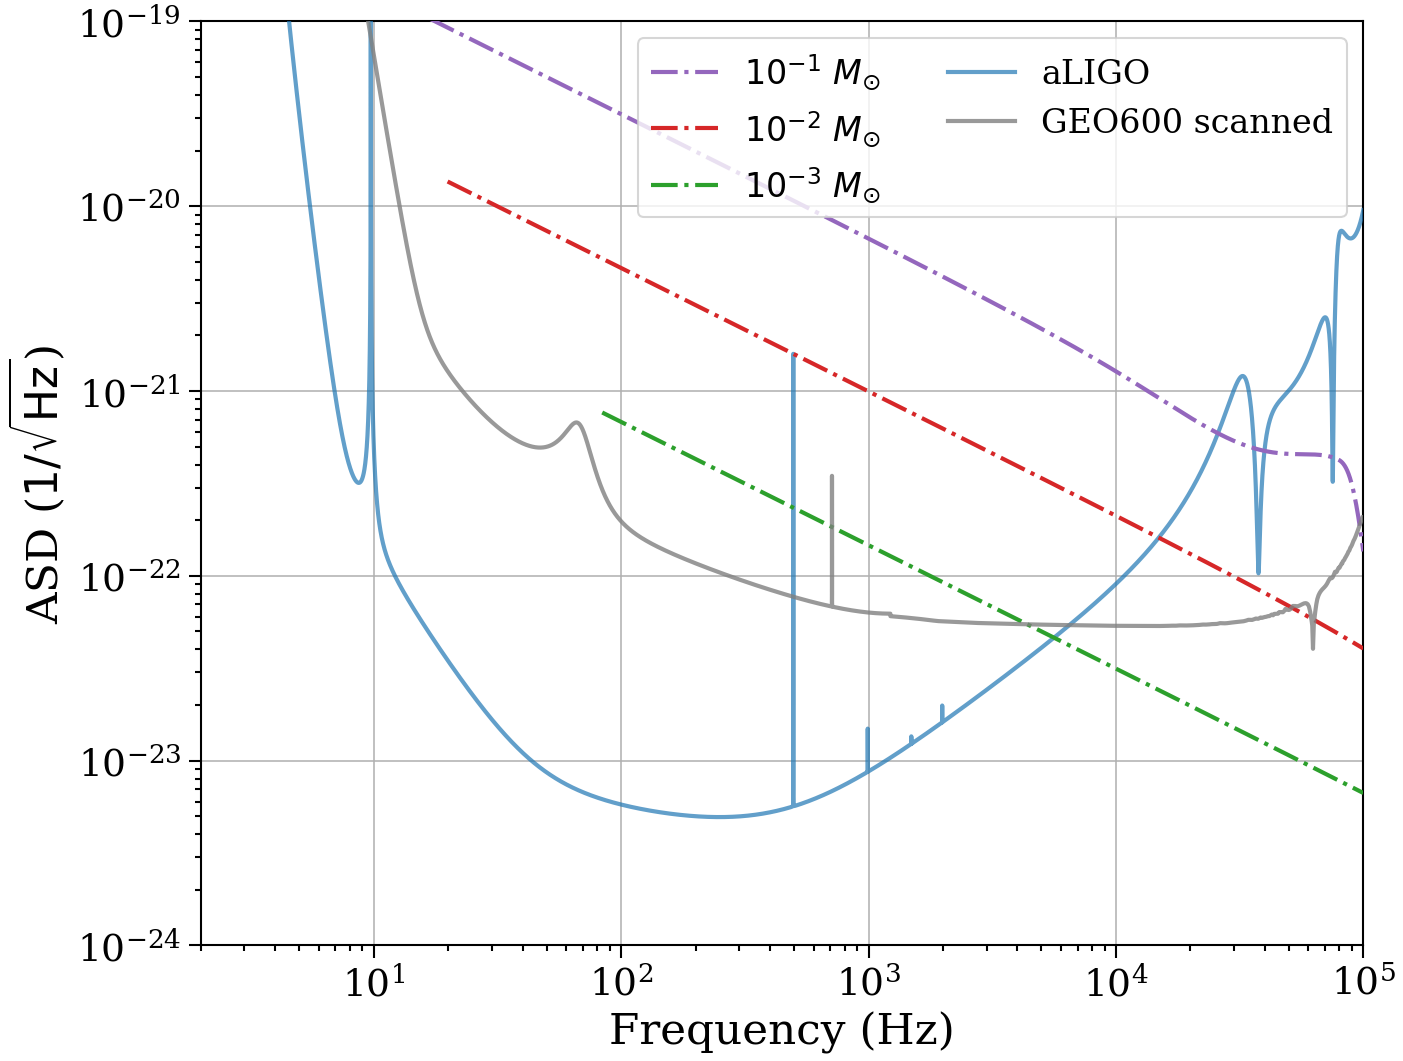

In [49]:
mb=ml = np.logspace(-3, -1, 3) #black hole solar mass
Mc = pycbc.conversions.mchirp_from_mass1_mass2(ml,mb)
q = mb/ml
T_obs_secs =  604800
dist = 0.03 # distance of boson cloud in Mpc

# Load in the antenna pattern arrays for LIGO and CE:
with np.load('LIGO_F_rms_100000_05.npz') as data:
        F_LIGO = data['F_rms']
with np.load('CE_F_rms_100000_05.npz') as data:
        F_CE = data['F_rms']

# Create list of strain waveforms and frequencies
hAveList = []
freqsList = []
for i in range(len(mb)):
    min_freq = get_f_min(Mc[i], T_obs_secs)
    max_freq = np.minimum((1/(2*(ml[i]+mb[i])*lal.MTSUN_SI)),100000)
    freqRange = np.abs(int(max_freq)-int(min_freq)+1)
    freqs = np.logspace(np.log10(min_freq),np.log10(max_freq),freqRange)
    freqsList.append(freqs)
    hAveList.append(get_strain(mb[i], q[i], dist, freqs))
    
# Create list of ASDs
Int_ASD_list = []
label_list = []
with np.load('ASD_50W_100000_05.npz') as data:
    
    # Access the Cosmic Explorer array:
    # asd_arrayC = data['CE']/F_CE
    # Int_ASD_list.append(asd_arrayC)
    # label_list.append('CE')
    
    # Access the aLIGO array:
    asd_arrayL = data['aLIGO']/F_LIGO
    Int_ASD_list.append(asd_arrayL)
    label_list.append('aLIGO')
    
    # Access the GEO600 array:
    # asd_arrayG = data['GEO600']
    # Int_ASD_list.append(asd_arrayG)
    # label_list.append('GEO600')
    
    # Access the GEO600 anti-tuned array:
    # asd_arrayG3 = data['GEO600_90']
    # Int_ASD_list.append(asd_arrayG3)
    # label_list.append('GEO600 anti-tuned')
    
    # Access the GEO600 scanned array:
    asd_arrayG4 = data['GEO600 Scanned']
    Int_ASD_list.append(asd_arrayG4)
    label_list.append('GEO600 scanned')
    
plot_ASD(Int_ASD_list, label_list, hAveList, freqsList)